In [1]:
%%javascript
$(document).ready(() => {
    // Удаление данного блока кода с конечного результата.
    $('div.code_cell').first().css('display', 'none');

    // Включение автоматического переноса слов в параграфе.
    $('div.text_cell p').css('hyphens', 'auto');

    // Включение растягивания текста на всю доступную длину.
    $('div.text_cell p').css('text-align', 'justify');
});

<IPython.core.display.Javascript object>

<h3><b>Лабораторная работа №1: Линейная регрессия</b></h3>

<p lang="ru">Линейная регрессия — метод восстановления зависимости одной объясняемой переменной $y$ от другой или нескольких других переменных $x$ с линейной функцией зависимости. Данный метод позволяет предсказывать значения зависимой переменной по значениям независимой. Линейная регрессия относится к задаче определения «линии наилучшего соответствия» через набор точек данных и является простым предшественником нелинейных методов, которые используются для обучения нейронных сетей.</p>

In [2]:
%autosave 300

Autosaving every 300 seconds


In [3]:
import warnings

# Игнорирование оповещающих сообщений внешних библиотек.
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
import numpy as np
import pandas as pd

In [5]:
# Импортирование библиотек для работы с графиками.
from matplotlib import pyplot
from mpl_toolkits import mplot3d
%matplotlib inline

In [6]:
# Установка начального значения для генератора случайных чисел.
# Данное действие требуется для воспроизведения результатов опыта.
np.random.seed(0)

In [7]:
def extend_values(values):
    # Добавление единичного столбца в качестве значений смещения.
    return np.c_[(np.ones(values.shape[0]), values)]

<p lang="ru"><b>Пункт №1:&nbsp;</b>Загрузка первого предоставленного набора данных <tt>ex1data1.txt</tt> при помощи внешней библиотеки pandas. Текущий набор данных содержит информацию о населении нескольких городов и прибыли некоторых ресторанов, достигнутой в этом городе. Отрицательные значения показателя прибыли означают, что в данном городе ресторан терпит убытки.</p>

In [8]:
# Устанака имен столбцов для использования, так как файл не содержит строку заголовка.
data = pd.read_csv('./datasets/ex1data1.txt', names=['Amount', 'Income'])

<p lang="ru"><b>Пункт №2:&nbsp;</b>Построение графика зависимости прибыли рассматриваемого ресторана от населения города, в котором он расположен. Всякую зависимость между двумя типами данных хорошо показывает диаграмма разброса значений. Ко всему прочему с помощью этой диаграммы можно определить корреляцию между каким-либо параметром качества и влияющим на него фактором.</p>

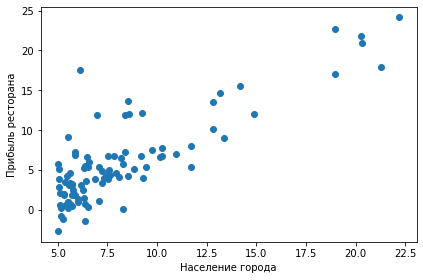

In [9]:
# Построение точечной диаграммы разброса данных.
pyplot.scatter(data['Amount'], data['Income'])

# Настройка координатных осей графика.
pyplot.xlabel('Население города')
pyplot.ylabel('Прибыль ресторана')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №3:&nbsp;</b>Реализация функции стоимости модели для набора данных <tt>ex1data1.txt</tt> при помощи внешней библиотеки numpy. Данная функция выражает меру количества ошибок, которые рассматриваемая модель делает на наборе данных. Хоть и существуют различные функции стоимости, все они вычисляют расстояние между предсказанным и фактическим значением.</p>

In [10]:
def calc_cost(w, x, y):
    # Функция вычисления значения стоимости математической модели.
    return np.sum(np.square(x.dot(w) - y)) / (2 * y.shape[0])

In [11]:
def calc_grad(w, x, y):
    # Функция вычисления градиента функции стоимости.
    return x.T.dot(x.dot(w) - y) / y.shape[0]

<p lang="ru"><b>Пункт №4:&nbsp;</b>Реализация алгоритма градиентного спуска с модификацией adam для выбора оптимальных параметров математической модели. Данная модификация стандартного алгоритма без труда справляется с проблемой впадин градиента и не так сильно подвержена застреванию в локальных минимумах функции, тем самым оптимизация происходит намного быстрее. Построение полученной модели совместно с графиком зависимости прибыли ресторана от населения города, в котором он расположен.</p>

In [12]:
def fmin_adam(x0, fprime, args=(), alpha=0.05, beta_1=0.9, beta_2=0.999, eps=1e-6, eps_min=1e-8):
    # Инициализация начального приближения модели.
    xx = x0[:]
    xi = x0[:]

    # Инициализация скользящих средних.
    m_t = np.zeros(xx.shape[0])
    v_t = np.zeros(xx.shape[0])

    funcalls = 1
    while True:
        # Вычисление значения градиента в данной точке.
        grad = fprime(xx, *args)

        # Обновление скользящих средних градиентов.
        m_t = beta_1 * m_t + (1 - beta_1) * grad
        v_t = beta_2 * v_t + (1 - beta_2) * np.square(grad)

        # Вычисление коррекции расчета алгоритма.
        mhat_t = m_t / (1 - (np.power(beta_1, funcalls)))
        vhat_t = v_t / (1 - (np.power(beta_2, funcalls)))

        # Пересчет значений параметров модели.
        xi = xx - (alpha * mhat_t) / (np.sqrt(vhat_t) + eps_min)

        # Условие остановки алгоритма оптимизации.
        if np.sum(abs(xi - xx)) <= eps:
            break

        funcalls += 1
        xx = xi  # Обновите значения параметров на новые.

    return xx.ravel()

In [13]:
data_x = data['Amount'].values
data_y = data['Income'].values.ravel()

# Добавление дополнительных значений смещения.
data_x = extend_values(data_x)

In [14]:
%%time

# Инициализация начальных параметров модели.
prime = np.zeros(data_x.shape[1])

# Запуск оптимизации математической модели.
thetas = fmin_adam(x0=prime, fprime=calc_grad, args=(data_x, data_y))

CPU times: user 42.5 ms, sys: 1.76 ms, total: 44.2 ms
Wall time: 46.2 ms


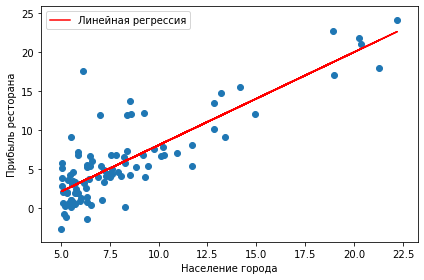

In [15]:
# Построение разделяющей линии полученной математической модели.
pyplot.plot(data['Amount'], data_x.dot(thetas), label='Линейная регрессия', color='r')

# Построение легенды графика.
pyplot.legend(loc='best')

# Построение точечной диаграммы разброса данных.
pyplot.scatter(data['Amount'], data['Income'])

# Настройка координатных осей графика.
pyplot.xlabel('Население города')
pyplot.ylabel('Прибыль ресторана')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №5:&nbsp;</b>Построение трехмерного графика зависимости функции стоимости от параметров математической модели в виде гиперплоскости и изолиний. Данное действие необходимо для визуальной оценки корректности математической модели к обобщению данных.</p>

In [16]:
x = np.linspace(-thetas[0]*3, thetas[0]*3, 300)
y = np.linspace(-thetas[1]*3, thetas[1]*3, 300)

z = np.zeros((y.shape[0], x.shape[0]))
for i, x_i in enumerate(y):
    for ii, x_ii in enumerate(x):
        z[i, ii] = calc_cost([x_ii, x_i], data_x, data_y)

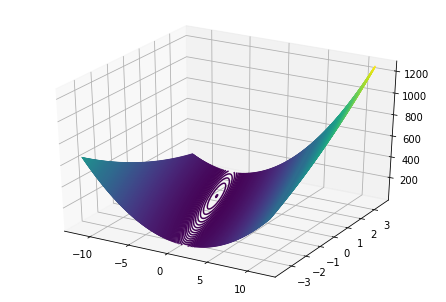

In [17]:
# Построение трехмерного графика функции стоимости модели.
ax = mplot3d.Axes3D(pyplot.figure())
ax.contour3D(x, y, z.T, 1000)

# Отображение графика.
pyplot.show()

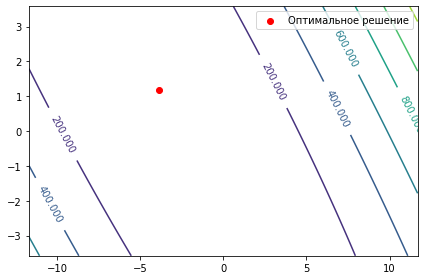

In [18]:
# Отображение точки глобального минимума рассматриваемой функции.
pyplot.scatter(thetas[0], thetas[1], label='Оптимальное решение', color='r')

# Построение легенды графика.
pyplot.legend(loc='best')

# Построение изолиний функции стоимости модели.
contours = pyplot.contour(x, y, z.T)
pyplot.clabel(contours, inline=1, fontsize=10)

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

***

<p lang="ru"><b>Пункт №6:&nbsp;</b>Загрузка второго предоставленного набора данных <tt>ex1data2.txt</tt> при помощи внешней библиотеки pandas. Текущий набор данных содержит информацию о площади дома в квадратных футах, количестве комнат в доме и стоимости данного дома.</p>

In [19]:
# Устанака имен столбцов для использования, так как файл не содержит строку заголовка.
data = pd.read_csv('./datasets/ex1data2.txt', names=['Areas', 'Count', 'Price'])

<p lang="ru"><b>Пункт №7:&nbsp;</b>Произведение нормализации признаков и сравнение их с ненормализованными. Если рассмотреть предоставленный набор данных, то можно заметить, что размеры домов в несколько раз превышают количество комнат. Такое отличие может привести к тому, что один признак будет очень сильно выделятся по сравнению с остальными, что в дальнейшем отразится на скорости схождения алгоритма. Помимо этого, при очень большой разнице значений, алгоритм может и вовсе не сойтись.</p>

In [20]:
data_x = data[['Areas', 'Count']].values
data_y = data['Price'].values.ravel()

# Добавление дополнительных значений смещения.
data_x = extend_values(data_x)

# Произведение нормализации признаков рассматриваемого набора данных.
data_norm = ((data - data.mean()) / data.std())[['Areas', 'Count']].values

# Добавление дополнительных значений смещения.
data_norm = extend_values(data_norm)

In [21]:
def fmin_mgd(x0, func, fprime, args=(), num_epochs=15, alpha=0.01, beta_1=0.9):
    # Инициализация начального приближения.
    xx = x0[:]

    # Контейнер для истории значений функции стоимости.
    cost_record = []

    velocity = 0
    for _ in range(num_epochs):
        # Вычисление значения градиента в данной точке.
        grad = fprime(xx, *args)

        # Обновление скорости момента схождения.
        velocity = beta_1 * velocity + (1 - beta_1) * grad

        # Пересчет значений параметров модели.
        xx -= alpha * velocity

        # Вычисление значения функции стоимости в данной точке.
        cost_record.append(func(xx, *args))

    return cost_record

In [22]:
%%time

# Инициализация начальных параметров модели.
prime = np.zeros(data_norm.shape[1])

# Запуск оптимизаций математических моделей.
log0 = fmin_mgd(func=calc_cost, x0=prime, fprime=calc_grad, args=(data_x, data_y))
log1 = fmin_mgd(func=calc_cost, x0=prime, fprime=calc_grad, args=(data_norm, data_y))

CPU times: user 2.84 ms, sys: 2.13 ms, total: 4.96 ms
Wall time: 3.93 ms


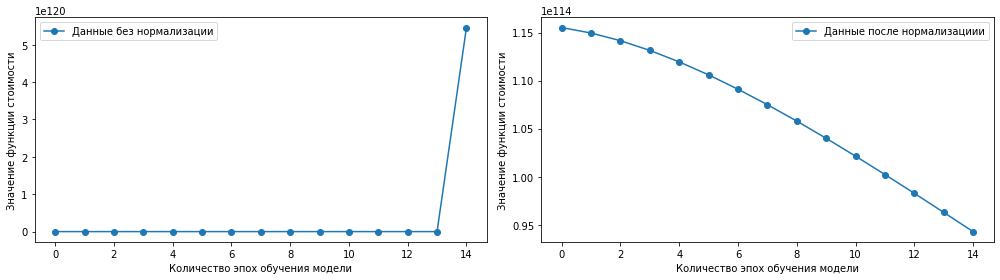

In [23]:
# Создание совместного полотна для графиков.
figure, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Построение графика значений стоимости до нормализации данных.
axes[0].plot(log0, label='Данные без нормализации', marker='o')

# Настройка координатных осей графика.
axes[0].set_xlabel('Количество эпох обучения модели')
axes[0].set_ylabel('Значение функции стоимости')

# Построение легенды графика.
axes[0].legend(loc='best')

# Построение графика значений стоимости после нормализации данных.
axes[1].plot(log1, label='Данные после нормализациии', marker='o')

# Настройка координатных осей графика.
axes[1].set_xlabel('Количество эпох обучения модели')
axes[1].set_ylabel('Значение функции стоимости')

# Построение легенды графика.
axes[1].legend(loc='best')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show(figure)

<p lang="ru"><b>Пункт №8:&nbsp;</b>Доказательство того, что векторизация дает прирост производительности. Если сравнивать между собой два подхода в реализации функции стоимости, можно заметить факт, что итеративная реализация алгоритма подсчета значения стоимости модели работает намного больше, чем реализация с использованием векторизации. Используя алгоритм, основанный на векторизации при обучении модели на большом объеме данных, можно выиграть много времени.</p>

In [24]:
# Инициализация начальных параметров модели.
thetas = np.zeros(data_x.shape[1])

In [25]:
%%time

# Начальное значение стоимости.
cost = 0

# Вычисление значение стоимости итеративно.
for i in range(data_x.shape[0]):
    hypo = 0
    for ii in range(data_x.shape[1]):
        hypo += thetas[ii] * data_x[i, ii]
    cost += np.square(hypo - data_y[i])

# Обновляем значение стоимости.
cost = cost / (2 * data_x.shape[0])

CPU times: user 796 µs, sys: 357 µs, total: 1.15 ms
Wall time: 6.77 ms


In [26]:
%%time

cost = calc_cost(thetas, data_x, data_y)

CPU times: user 81 µs, sys: 14 µs, total: 95 µs
Wall time: 88 µs


<p lang="ru"><b>Пункт №9:&nbsp;</b>Зависимость скорости схождения алгоритма от значения скорости обучения. Побдор скорости обучения является важным этапом в машинном обучении, так как от значения этого гиперпараметра зависит как точность конечной модели, так и скорость ее обучения. При очень маленьком значении обучение будет протекать очень медленно, а при быстром есть шанс пропустить минимум функции.</p>

In [27]:
%%time

# Инициализация начальных параметров модели.
thetas = np.ones(data_norm.shape[1])

# Запуск оптимизаций математических моделей.
log0 = fmin_mgd(func=calc_cost, x0=thetas, fprime=calc_grad, args=(data_norm, data_y), alpha=0.01)
log1 = fmin_mgd(func=calc_cost, x0=thetas, fprime=calc_grad, args=(data_norm, data_y), alpha=0.05)

CPU times: user 2.62 ms, sys: 1.45 ms, total: 4.07 ms
Wall time: 3.82 ms


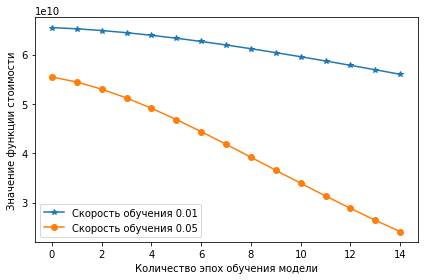

In [28]:
# Построение графиков значений стоимости при разных значениях скорости обучения.
pyplot.plot(log0, label='Скорость обучения 0.01', marker='*')
pyplot.plot(log1, label='Скорость обучения 0.05', marker='o')

# Настройка координатных осей графика.
pyplot.xlabel('Количество эпох обучения модели')
pyplot.ylabel('Значение функции стоимости')

# Построение легенды графика.
pyplot.legend(loc='best')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №10:&nbsp;</b>Решение задачи линейной регресии с помощью метоад наименьших квадратов. Данный подход целесообразно применять только для очень маленького набора данных в силу его асимптотической сложности. Дело в том, что вычисление обратной матрицы достаточно затратная операция и для больших моделей такой подход будет проигрывать в скорости алгоритму градиентного спуска в несколько раз.</p>

In [29]:
%%time

# Вычисление параметров модели с помощью аналитического решения.
np.linalg.inv(data_norm.T.dot(data_norm)).dot(data_norm.T).dot(data_y)

CPU times: user 220 µs, sys: 94 µs, total: 314 µs
Wall time: 414 µs


array([340412.65957447, 110631.05027885,  -6649.47427082])